# PCA-LDA

Given a collection of of n m-dimensional samples stored in the columns of matrix $X = [x_1 , . . . , x_n ]$. We also assume that data are centered. Otherwise, we can always substract the mean $m = \frac{1}{n} \sum_{i=1}^{n}x_i$.

An efficient way of doing this is:

\begin{align*}
X − M = X \left(I − \frac{1}{n}1_n1_n^T \right)
\end{align*}

## Statistical perspective
We want to find the vector $w$ such that the variance of the projected features $y_i = w_i^Tx_i$ is maximised.The variance can be expressed:

\begin{align*}
\sigma_y^2 = \frac{1}{n} \sum_{i=1}^{n}(y_i - \mu_y)
\end{align*}

Where $\mu_y$ is the mean. Since we supposed the data are centered, $\mu_y = 0$.

The maximiser is:

\begin{align*}
w^* & = \mathrm{argmax}_{w} \frac{1}{2n} \sum_{i=1}^{n}(w^Tx_i)^2 = \mathrm{argmax}_{w}  \frac{1}{2n} \sum_{i=1}^{n}w^Tx_i x_i^Tw\\
& = \mathrm{argmax}_{w} \frac{1}{2} w^T\frac{XX^T}{n}w  = \mathrm{argmax}_{w} \frac{1}{2} w^T S_tw  
\end{align*}

Where $S_t = \frac{XX^T}{n}$ is called the covariance matrix (or total-scatter matrix). We add the following constraint not to end up with a trivial solution $w=\infty$.

\begin{align*}
w^*  &= \mathrm{argmax}_{w} \frac{1}{2} w^T S_tw \\
\text{subject to } &w^Tw=1
\end{align*}

The corresponding Lagrangian is:

\begin{align*}
L(w, \lambda) = \frac{1}{2}w^TS_tw - \lambda(w^Tw-1)
\end{align*}

Taking the derivative:
\begin{align*}
\frac{ \partial L}{\partial w} = S_tw - \lambda w = 0
\end{align*}

This means $w$ is an eigenvector of $S_t$, and $\lambda$ the corresponding eigenvalue. Plugging back this expression in the initial problem:

\begin{align*}
\lambda^* = \mathrm{argmax}_{\lambda} \lambda
\end{align*}

So the largest eigenvalue is chosen.

This reasonning can be applied for $y_i \in \mathbb{R}^d$:

\begin{align*}
W^* =& \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} y_{ki}^2  = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} (w_k^Tx_i)^2 \\
& = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} w_k^Tx_ix_i^Tw_k \\
& = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d}  w_k^T \left(\sum_{i=1}^{n}x_ix_i^T \right)w_k \\
& = \mathrm{argmax}_{W} \frac{1}{2} \sum_{k=1}^{d}  w_k^T S_t w_k \\
& = \mathrm{argmax}_{W} \frac{1}{2} \mathrm{Tr} (W^T S_t W) \\
\end{align*}

So the general problem is:

\begin{align*}
\max_W \mathrm{Tr} (W^T S_tW) \\
\text{subject to } &W^TW=1
\end{align*}

Taking the partial derivative of the Lagrangian leads to a similar condition:

\begin{align*}
S_tW=W\Lambda
\end{align*}

Where $\Lambda$ is the matrix of the Lagrange multipliers.

Assuming the eigendecomposition of $S_t$ is $S_t = U \Lambda U^T$, then $W = U_d = [u_1, ..., u_d]$.

Similarly as above, the cost function can be written as:

\begin{align*}
    \mathrm{Tr}(W^TS_TW) = \mathrm{Tr}(W^T U \Lambda U^T W) = \mathrm{Tr}(\Lambda_d) = \sum_{k=1}^{d} \lambda_k
\end{align*}

Since $\lambda_k \ge 0$, maximisation of the above is equivalent to take the $d$ largest eigenvalues.

In [39]:
# http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html
# https://github.com/jindongwang/transferlearning/blob/master/data/dataset.md
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
fea = pd.read_csv("fea64.csv", header=None) 
gnd = pd.read_csv("gnd64.csv", header=None) 
Train = pd.read_csv("Train5_64.csv", header=None) 

In [85]:
print('fea:', fea.shape) # each row is a 64x64 image (11554 examples)
print('gnd:', gnd.shape) # label: 68 classes corresponding to the 68 subjects (11554 examples)
print('Train:', Train.shape) 

fea: (11554, 4096)
gnd: (11554, 1)
Train: (100, 340)


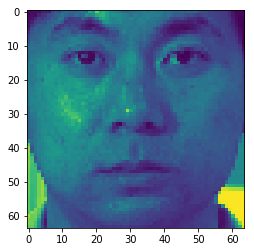

In [82]:
ind = np.random.randint(fea.shape[0])
img = fea.values[ind,:].reshape(64,64).T
imgplot = plt.imshow(img)

In [234]:
def PCA(data, dim):
    n, m = data.shape
    
    mean = 1/n*np.sum(data, axis = 0)
    data = data - mean
    
    w, v = np.linalg.eig(data @ data.T)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    w = np.diag(w)
    v = v[:,idx]
    
    u = data.T @ v @ w
    
    return u

In [235]:
a = fea.values[:3,:]
a.shape

(3, 4096)

In [236]:
u = PCA(a, 1)

In [239]:
u.shape

(4096, 3)

In [28]:
X = X';  %taking the transpose to fit the notations in the lecture notes

[n, m] = size(X); %getting the number of lines and columns
 
X = X*(eye(m)-1/(n*m)*ones(m,1)*transpose(ones(m,1))); %subtract the mean to the data
 
[V,D] = eig(X'*X); %finding the eigenvectors V and eigenvalues D of the matrix of lower dimensions
 
[~,ind] = sort(diag(D), 'descend'); % sorting the eigenvalues by putting the greater ones at the beginning
 
Ds = D(ind,ind); % reordering the eigenvalue
 
Vs = V(:,ind); % reordering the eigenvectors
 
U = X*Vs*Ds^(-0.5); %building the eigenvectors of the matrix of greater dimensions
 
Ud = U(:,1:dim); % choosing a chosen number of "dim" vectors
 
ReturnVal = Ud;